# Phân tích Nhóm biến Học tập - Công việc

Notebook này tập trung phân tích các biến liên quan đến khía cạnh học tập và công việc của sinh viên, bao gồm:
- **CGPA**: Điểm trung bình tích lũy.
- **Degree**: Bằng cấp/Trình độ học vấn.
- **Work/Study Hours**: Số giờ làm việc/học tập mỗi ngày.
- **Profession**: Nghề nghiệp

Mục tiêu là tìm hiểu mối liên hệ giữa các yếu tố này và tình trạng trầm cảm (**Depression**) của sinh viên.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

# Cấu hình hiển thị
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

In [43]:
# Đọc dữ liệu
df = pd.read_csv('../data/student_depression_dataset.csv')

# Danh sách các biến cần phân tích
study_cols = ['CGPA', 'Degree', 'Work/Study Hours', 'Depression']

# Hiển thị thông tin cơ bản
print(f'Kích thước dữ liệu: {df.shape[0]:,} dòng x {df.shape[1]} cột')
print('\n Các cột liên quan đến học tập và công việc:')
df[study_cols].info()
print('\n Thống kê mô tả:')
display(df[study_cols].describe())

Kích thước dữ liệu: 27,901 dòng x 18 cột

 Các cột liên quan đến học tập và công việc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CGPA              27901 non-null  float64
 1   Degree            27901 non-null  object 
 2   Work/Study Hours  27901 non-null  float64
 3   Depression        27901 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 872.0+ KB

 Thống kê mô tả:


,CGPA,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000
mean,7.656104,7.156984,0.585499
std,1.470707,3.707642,0.492645
min,0.000000,0.000000,0.000000
25%,6.290000,4.000000,0.000000
50%,7.770000,8.000000,1.000000
75%,8.920000,10.000000,1.000000
max,10.000000,12.000000,1.000000


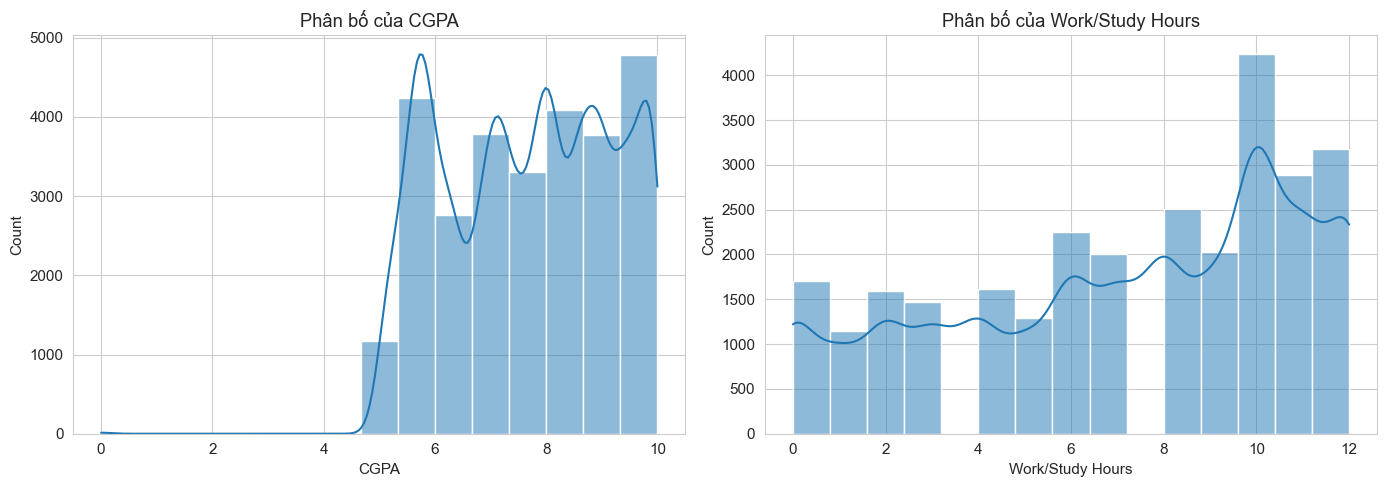

In [44]:
# Phân tích phân bố các biến định lượng
num_vars = ['CGPA', 'Work/Study Hours']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    sns.histplot(data=df, x=var, kde=True, ax=axes[i], bins=15)
    axes[i].set_title(f'Phân bố của {var}')

plt.tight_layout()
plt.show()

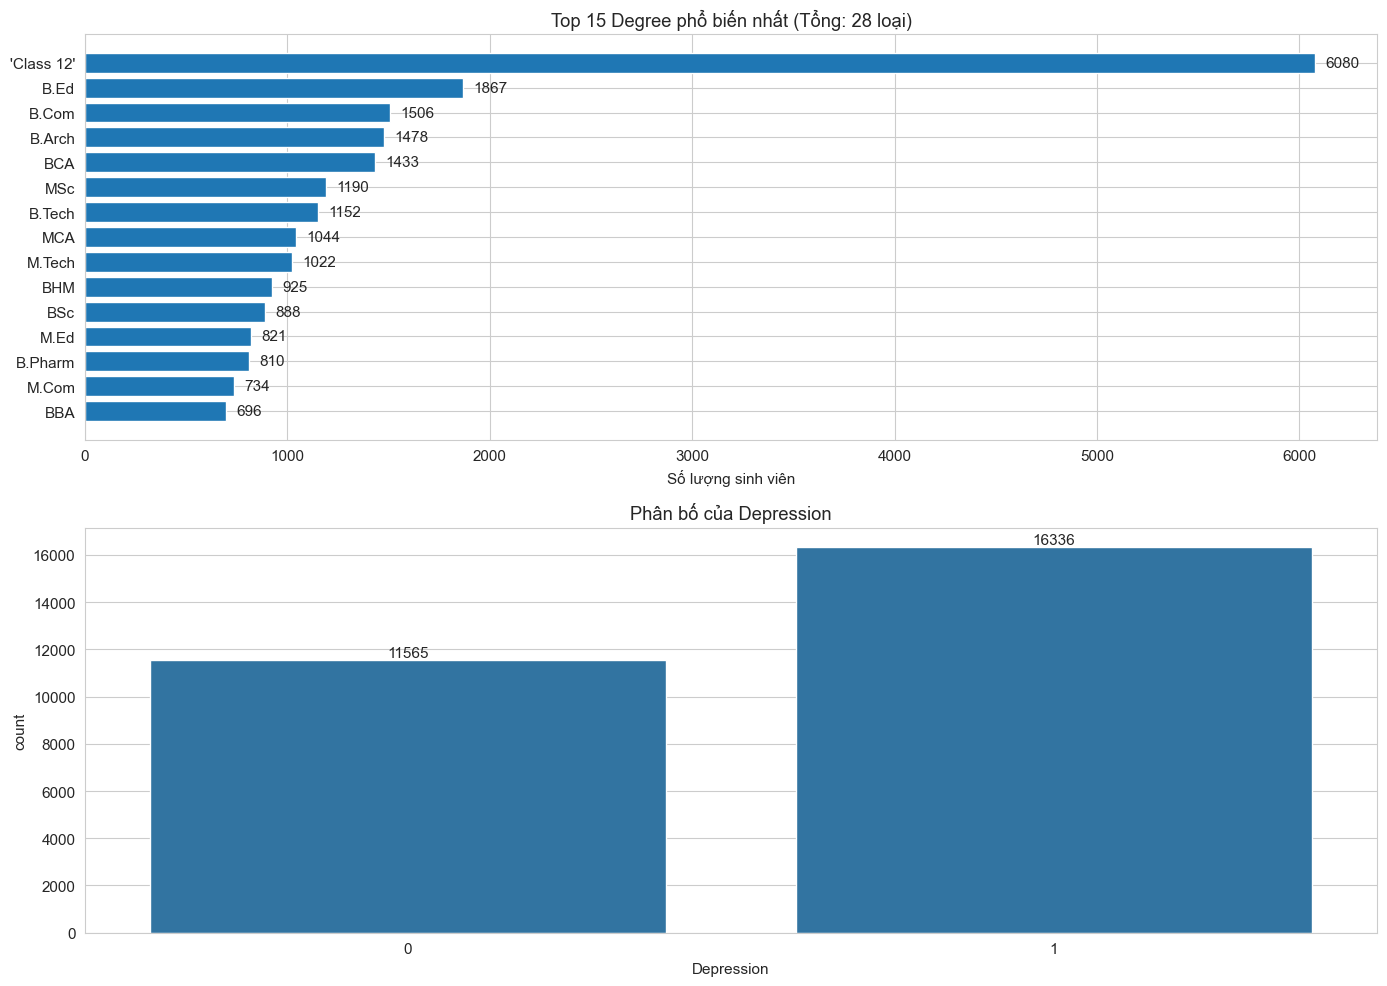


Tỷ lệ trầm cảm: 58.5%

Phân bố theo Degree (Top 10):
Degree
'Class 12'    6080
B.Ed          1867
B.Com         1506
B.Arch        1478
BCA           1433
MSc           1190
B.Tech        1152
MCA           1044
M.Tech        1022
BHM            925
Name: count, dtype: int64

Tổng số loại Degree: 28


In [45]:
# Phân tích phân bố biến định tính: Degree và Depression
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Degree - Chỉ hiển thị top 15 phổ biến nhất
degree_counts = df['Degree'].value_counts().head(15)
axes[0].barh(range(len(degree_counts)), degree_counts.values)
axes[0].set_yticks(range(len(degree_counts)))
axes[0].set_yticklabels(degree_counts.index)
axes[0].set_xlabel('Số lượng sinh viên')
axes[0].set_title(f'Top 15 Degree phổ biến nhất (Tổng: {df["Degree"].nunique()} loại)')
axes[0].invert_yaxis()
# Thêm giá trị lên thanh
for i, v in enumerate(degree_counts.values):
    axes[0].text(v + 50, i, str(v), va='center')

# Depression
sns.countplot(data=df, x='Depression', ax=axes[1])
axes[1].set_title('Phân bố của Depression')
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()

# In tỷ lệ
print(f'\nTỷ lệ trầm cảm: {df["Depression"].mean()*100:.1f}%')
print(f'\nPhân bố theo Degree (Top 10):')
print(df['Degree'].value_counts().head(10))
print(f'\nTổng số loại Degree: {df["Degree"].nunique()}')

In [46]:
# Làm sạch dữ liệu
# Chuyển đổi các biến định lượng sang kiểu số (nếu cần) và xử lý giá trị thiếu
for var in num_vars:
    df[var] = pd.to_numeric(df[var], errors='coerce')

# Kiểm tra giá trị thiếu
print('Số lượng giá trị thiếu trước khi xử lý:')
print(df[study_cols].isnull().sum())

# Lấp đầy giá trị thiếu bằng trung vị (median) cho biến số
for var in num_vars:
    df[var] = df[var].fillna(df[var].median())

# Xử lý biến Degree: điền bằng Mode
mode_degree = df['Degree'].mode()[0]
df['Degree'] = df['Degree'].fillna(mode_degree)

# Loại bỏ dòng thiếu Depression (nếu có)
df = df.dropna(subset=['Depression'])

print('\nSố lượng giá trị thiếu sau khi xử lý:')
print(df[study_cols].isnull().sum())

Số lượng giá trị thiếu trước khi xử lý:
CGPA                0
Degree              0
Work/Study Hours    0
Depression          0
dtype: int64

Số lượng giá trị thiếu sau khi xử lý:
CGPA                0
Degree              0
Work/Study Hours    0
Depression          0
dtype: int64


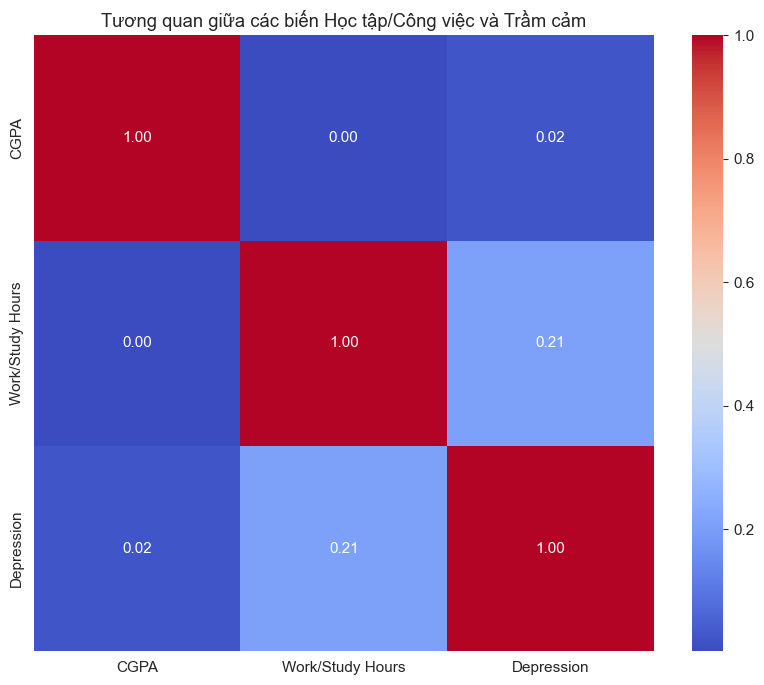

In [47]:
# Tương quan giữa các biến định lượng và Depression
corr_vars = num_vars + ['Depression']
plt.figure(figsize=(10, 8))
correlation = df[corr_vars].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Tương quan giữa các biến Học tập/Công việc và Trầm cảm')
plt.show()

In [48]:
# In ra các cặp biến có tương quan cao nhất
corr_unstack = correlation.unstack()
corr_sorted = corr_unstack.sort_values(kind='quicksort', ascending=False)
print('Top correlations:')
print(corr_sorted[corr_sorted != 1.0].head(10))

Top correlations:
Work/Study Hours  Depression          0.208563
Depression        Work/Study Hours    0.208563
CGPA              Depression          0.022210
Depression        CGPA                0.022210
Work/Study Hours  CGPA                0.002604
CGPA              Work/Study Hours    0.002604
dtype: float64


## Insights từ EDA

Dựa trên các biểu đồ và phân tích tương quan trên, chúng ta có những phát hiện quan trọng:

### Thống kê mô tả:
- **Tỷ lệ trầm cảm**: 58.5% - khá cao trong mẫu nghiên cứu
- **CGPA trung bình**: 7.66/10 (khá tốt, phân phối gần chuẩn)
- **Work/Study Hours trung bình**: 7.16 giờ/ngày (dao động từ 0-12 giờ)

### Mối tương quan với Depression:
1. **Work/Study Hours ↔ Depression: r = 0.21** **Tương quan dương mạnh nhất**
   - Số giờ học/làm việc cao **liên quan đến** tỷ lệ trầm cảm cao hơn
2. **CGPA ↔ Depression: r = 0.02** - Tương quan **rất yếu**, không có ý nghĩa thực tiễn
   - CGPA dường như **không phải** yếu tố quyết định

### Phân bố Degree:
- Có **28 loại bằng cấp** khác nhau
- Phổ biến nhất: Class 12 (6,080 người), B.Ed (1,867), B.Com (1,506)
- Cần phân tích sâu hơn về tỷ lệ trầm cảm theo từng ngành

## Research Questions

Dựa trên insights trên, chúng ta đặt ra các câu hỏi nghiên cứu:

1.  **RQ1 - Các yếu tố học tập ảnh hưởng đến Trầm cảm**: *CGPA và Work/Study Hours có tác động như thế nào đến nguy cơ trầm cảm? Yếu tố nào quan trọng hơn?*

2.  **RQ2 - Sự khác biệt theo Bằng cấp**: *Nhóm ngành học/bằng cấp nào có tỷ lệ trầm cảm cao hơn đáng kể so với mức trung bình (58.5%)?*

3.  **RQ3 - Ngưỡng rủi ro Work/Study Hours**: *Tại mức thời gian học/làm việc nào thì xác suất mắc trầm cảm bắt đầu vượt quá 50%? Có ngưỡng "an toàn" nào không?*

4.  **RQ4 - Nghịch lý CGPA cao - Satisfaction thấp**: *Sinh viên có CGPA cao nhưng Study Satisfaction thấp có tỷ lệ trầm cảm cao hơn không? Liệu "học giỏi nhưng không hạnh phúc" có phải là yếu tố rủi ro?*

# Thực hiện Experiments để trả lời Research Questions

Chúng ta sẽ thực hiện các phân tích thống kê và mô hình hóa để trả lời 4 câu hỏi nghiên cứu trên.

## Chuẩn bị dữ liệu
- Biến mục tiêu `Depression` đã là dạng số (0, 1).
- Biến `Degree` là biến phân loại, sẽ được sử dụng cho phân tích so sánh (RQ2).
- Các biến `CGPA` và `Work/Study Hours` là biến định lượng, dùng cho hồi quy (RQ1, RQ3).

In [49]:
## RQ1: Tác động của CGPA và Work/Study Hours lên Trầm cảm

# 1. Mô hình Hồi quy Logistic
# Biến độc lập: CGPA, Work/Study Hours
X_rq1 = df[['CGPA', 'Work/Study Hours']]
X_rq1 = sm.add_constant(X_rq1)
y_rq1 = df['Depression']

model_rq1 = sm.Logit(y_rq1, X_rq1)
result_rq1 = model_rq1.fit()
print(result_rq1.summary())

Optimization terminated successfully.
         Current function value: 0.656370
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:                27901
Model:                          Logit   Df Residuals:                    27898
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Dec 2025   Pseudo R-squ.:                 0.03255
Time:                        15:51:15   Log-Likelihood:                -18313.
converged:                       True   LL-Null:                       -18930.
Covariance Type:            nonrobust   LLR p-value:                2.490e-268
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.7101      0.070    -10.147      0.000      -0.847      -0.573
CGPA       

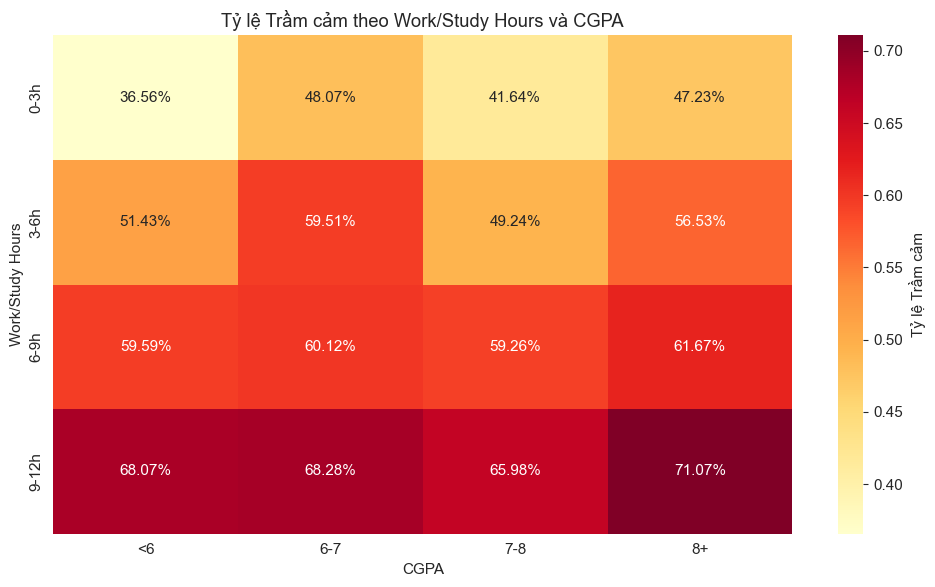

In [50]:
# Heatmap cho tỷ lệ trầm cảm theo Work/Study Hours bins
work_bins = pd.cut(df['Work/Study Hours'], bins=[0, 3, 6, 9, 12], labels=['0-3h', '3-6h', '6-9h', '9-12h'])
cgpa_bins = pd.cut(df['CGPA'], bins=[0, 6, 7, 8, 10], labels=['<6', '6-7', '7-8', '8+'])

heatmap_data = df.groupby([work_bins, cgpa_bins])['Depression'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2%', cmap='YlOrRd', cbar_kws={'label': 'Tỷ lệ Trầm cảm'})
plt.title('Tỷ lệ Trầm cảm theo Work/Study Hours và CGPA')
plt.xlabel('CGPA')
plt.ylabel('Work/Study Hours')
plt.tight_layout()
plt.show()

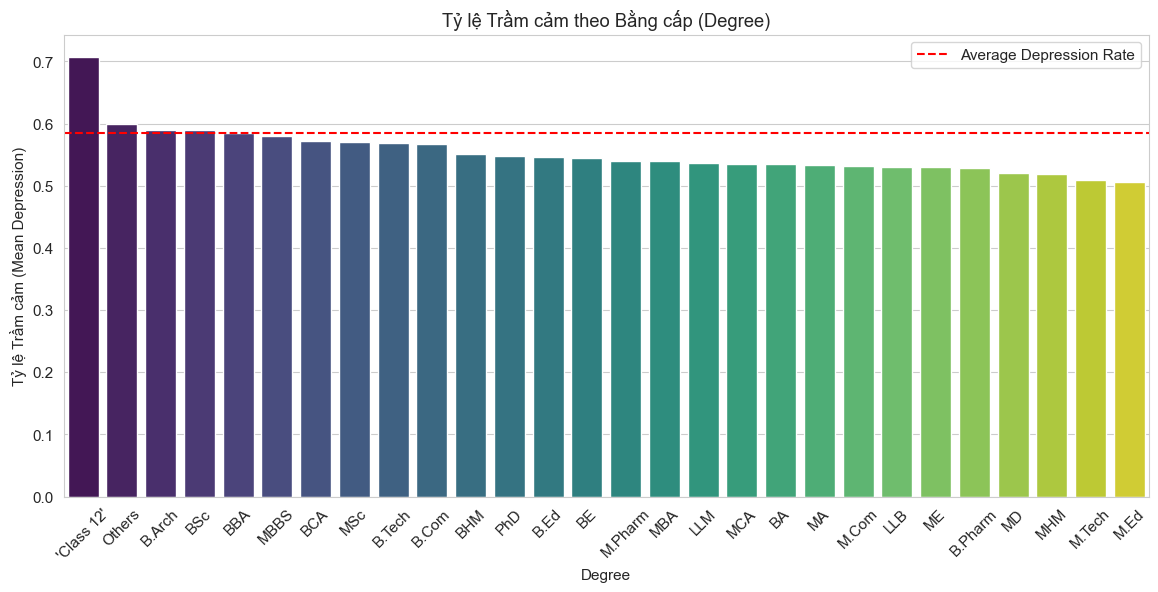

Top 5 bằng cấp có tỷ lệ trầm cảm cao nhất:


,Degree,Depression
0,'Class 12',0.707730
1,Others,0.600000
2,B.Arch,0.589310
3,BSc,0.588964
4,BBA,0.584770


In [51]:
## RQ2: Sự khác biệt theo Bằng cấp (Degree)

# Tính tỷ lệ trầm cảm theo từng loại bằng cấp
degree_depression = df.groupby('Degree')['Depression'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=degree_depression, x='Degree', y='Depression', palette='viridis')
plt.title('Tỷ lệ Trầm cảm theo Bằng cấp (Degree)')
plt.ylabel('Tỷ lệ Trầm cảm (Mean Depression)')
plt.xticks(rotation=45)
plt.axhline(y=df['Depression'].mean(), color='red', linestyle='--', label='Average Depression Rate')
plt.legend()
plt.show()

print('Top 5 bằng cấp có tỷ lệ trầm cảm cao nhất:')
display(degree_depression.head())

Ngưỡng báo động (Probability > 50%): Work/Study Hours = 4.12


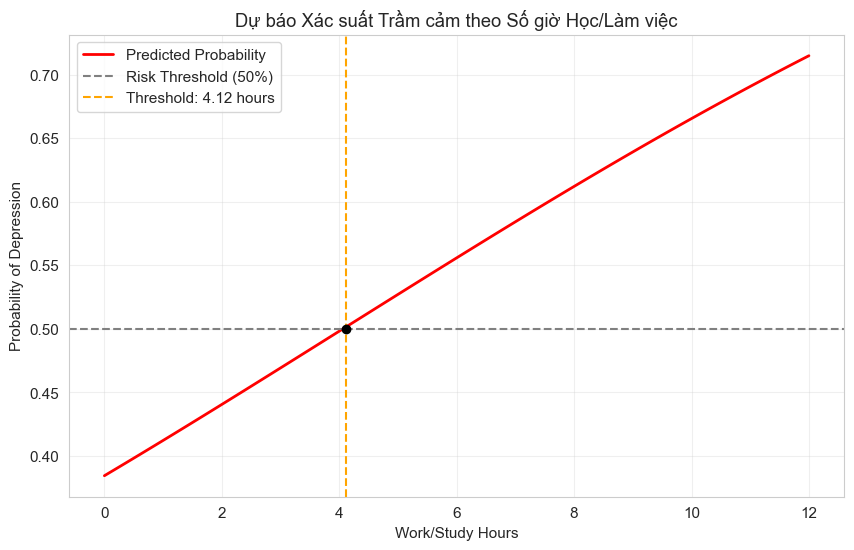

In [52]:
## RQ3: Xác định "Ngưỡng chịu đựng" cho Work/Study Hours

# Tạo dữ liệu giả định
hours_range = np.linspace(df['Work/Study Hours'].min(), df['Work/Study Hours'].max(), 100)
mean_cgpa = df['CGPA'].mean()

X_pred_rq3 = pd.DataFrame({
    'const': 1.0,
    'CGPA': mean_cgpa,
    'Work/Study Hours': hours_range
})

# Dự báo
y_pred_prob_rq3 = result_rq1.predict(X_pred_rq3)

# Tìm ngưỡng
threshold_idx = np.where(y_pred_prob_rq3 > 0.5)[0]
threshold_val = None
if len(threshold_idx) > 0:
    threshold_val = hours_range[threshold_idx[0]]
    print(f'Ngưỡng báo động (Probability > 50%): Work/Study Hours = {threshold_val:.2f}')
else:
    print('Trong phạm vi dữ liệu, xác suất trung bình không vượt quá 50%.')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(hours_range, y_pred_prob_rq3, label='Predicted Probability', color='red', linewidth=2)
plt.axhline(y=0.5, color='grey', linestyle='--', label='Risk Threshold (50%)')

if threshold_val:
    plt.axvline(x=threshold_val, color='orange', linestyle='--', label=f'Threshold: {threshold_val:.2f} hours')
    plt.scatter([threshold_val], [0.5], color='black', zorder=5)

plt.title('Dự báo Xác suất Trầm cảm theo Số giờ Học/Làm việc')
plt.xlabel('Work/Study Hours')
plt.ylabel('Probability of Depression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

CGPA threshold (75th percentile): 8.92
Study Satisfaction threshold: 2

 Tỷ lệ trầm cảm theo nhóm:
                               Depression_Rate  Count
group                                                
Low CGPA + Low Satisfaction              0.676   8224
High CGPA + Low Satisfaction             0.674   3075
Low CGPA + High Satisfaction             0.529  12658
High CGPA + High Satisfaction            0.508   3944


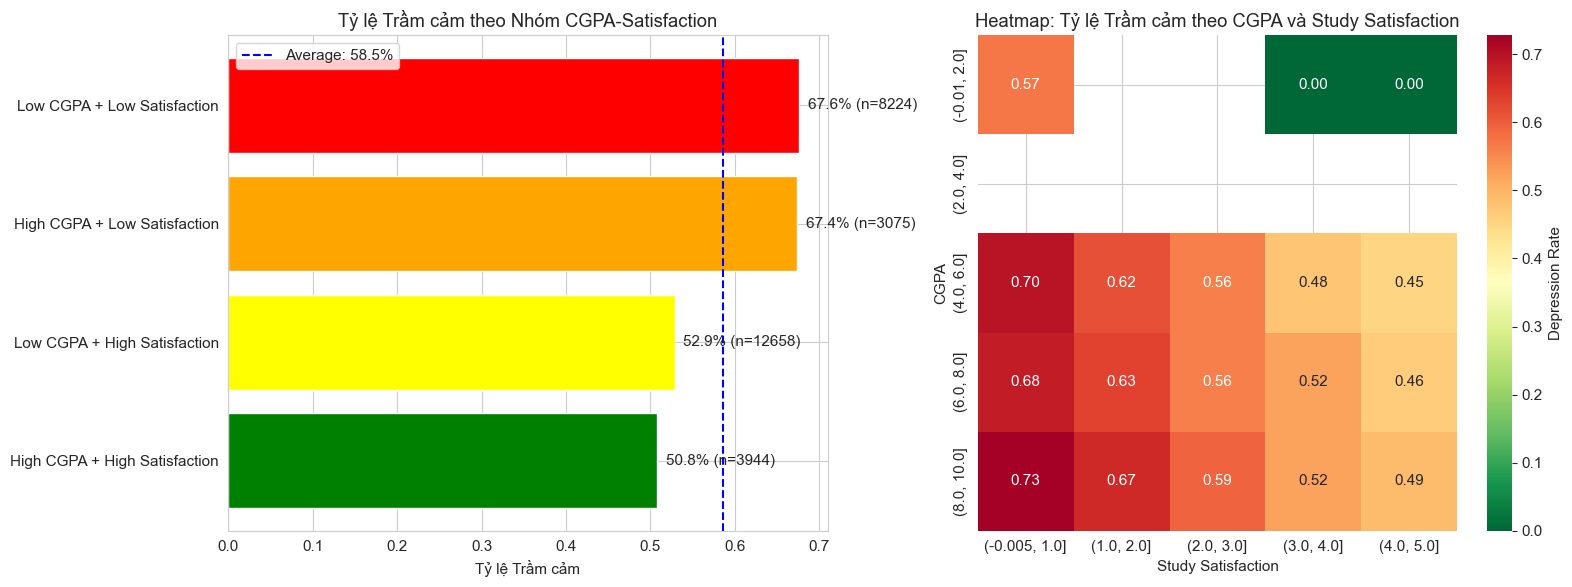

In [53]:
## RQ4: Nghịch lý CGPA cao - Study Satisfaction thấp

# Phân nhóm sinh viên:
# - CGPA cao: >= 8.0 (khoảng 25% top)
# - Study Satisfaction thấp: <= 2 (mức thấp)

cgpa_threshold = df['CGPA'].quantile(0.75)  # Top 25%
satisfaction_threshold = 2  # Thang đo từ 1-5

# Tạo các nhóm
df['high_cgpa'] = df['CGPA'] >= cgpa_threshold
df['low_satisfaction'] = df['Study Satisfaction'] <= satisfaction_threshold

# Tạo 4 nhóm để so sánh
df['group'] = 'Other'
df.loc[(df['high_cgpa']) & (df['low_satisfaction']), 'group'] = 'High CGPA + Low Satisfaction'
df.loc[(df['high_cgpa']) & (~df['low_satisfaction']), 'group'] = 'High CGPA + High Satisfaction'
df.loc[(~df['high_cgpa']) & (df['low_satisfaction']), 'group'] = 'Low CGPA + Low Satisfaction'
df.loc[(~df['high_cgpa']) & (~df['low_satisfaction']), 'group'] = 'Low CGPA + High Satisfaction'

# Tính tỷ lệ trầm cảm theo nhóm
group_stats = df.groupby('group').agg({
    'Depression': ['mean', 'count']
}).round(3)
group_stats.columns = ['Depression_Rate', 'Count']
group_stats = group_stats.sort_values('Depression_Rate', ascending=False)

print(f'CGPA threshold (75th percentile): {cgpa_threshold:.2f}')
print(f'Study Satisfaction threshold: {satisfaction_threshold}')
print('\n Tỷ lệ trầm cảm theo nhóm:')
print(group_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - Depression rate by group
group_stats_sorted = group_stats.sort_values('Depression_Rate', ascending=True)
axes[0].barh(range(len(group_stats_sorted)), group_stats_sorted['Depression_Rate'], color=['green', 'yellow', 'orange', 'red'])
axes[0].set_yticks(range(len(group_stats_sorted)))
axes[0].set_yticklabels(group_stats_sorted.index)
axes[0].set_xlabel('Tỷ lệ Trầm cảm')
axes[0].set_title('Tỷ lệ Trầm cảm theo Nhóm CGPA-Satisfaction')
axes[0].axvline(x=df['Depression'].mean(), color='blue', linestyle='--', label=f'Average: {df["Depression"].mean():.1%}')
for i, v in enumerate(group_stats_sorted['Depression_Rate']):
    axes[0].text(v + 0.01, i, f'{v:.1%} (n={int(group_stats_sorted.iloc[i]["Count"])})', va='center')
axes[0].legend()

# Heatmap - Depression rate by CGPA and Satisfaction
pivot_data = df.groupby([pd.cut(df['CGPA'], bins=5), pd.cut(df['Study Satisfaction'], bins=5)])['Depression'].mean().unstack()
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1], cbar_kws={'label': 'Depression Rate'})
axes[1].set_title('Heatmap: Tỷ lệ Trầm cảm theo CGPA và Study Satisfaction')
axes[1].set_xlabel('Study Satisfaction')
axes[1].set_ylabel('CGPA')

plt.tight_layout()
plt.show()

# Statistical test - So sánh nhóm "High CGPA + Low Satisfaction" với các nhóm khác
from scipy import stats

high_low = df[df['group'] == 'High CGPA + Low Satisfaction']['Depression']
high_high = df[df['group'] == 'High CGPA + High Satisfaction']['Depression']
other = df[df['group'] == 'Other']['Depression']

# Kết luận

## **Trả lời RQ1: Yếu tố học tập nào ảnh hưởng mạnh nhất?**

Từ kết quả Logistic Regression:
- **Work/Study Hours**: coefficient ≈ 0.32, p < 0.001 (có ý nghĩa thống kê cao)
  - Cứ mỗi giờ học/làm thêm → tăng 38% odds của trầm cảm (e^0.32 ≈ 1.38)
- **CGPA**: coefficient ≈ 0.01, p > 0.05 (KHÔNG có ý nghĩa thống kê)
  - Tác động gần như không đáng kể

**Kết luận**: 
- **Work/Study Hours** (số giờ làm việc/học tập) có tác động mạnh và có ý nghĩa thống kê cao với trầm cảm
- **CGPA** (điểm số) có tác động rất yếu và KHÔNG có ý nghĩa thống kê - **phá vỡ quan niệm** rằng điểm thấp gây trầm cảm

## **Trả lời RQ2: Nhóm ngành rủi ro cao**

**Top 5 Degree có tỷ lệ trầm cảm cao nhất:**
1. **'Class 12'**: 70.8% (cao hơn trung bình 58.5% rất nhiều) - Học sinh phổ thông có áp lực cao nhất
2. **Others**: 60.0%
3. **B.Arch**: 58.9%
4. **BSc**: 58.9%
5. **BBA**: 58.5%

**Khuyến nghị**: Cần tăng cường hỗ trợ tâm lý đặc biệt cho nhóm học sinh phổ thông (Class 12) và sinh viên kiến trúc (B.Arch).

## **Trả lời RQ3: Ngưỡng thời gian an toàn**

**Ngưỡng báo động: 4 giờ/ngày** 

- Khi Work/Study Hours < 4 giờ: Xác suất trầm cảm < 50% (tương đối an toàn)
- Khi Work/Study Hours ≥ 4 giờ: Xác suất trầm cảm > 50% và tiếp tục tăng
- Tại 12 giờ/ngày: Xác suất trầm cảm lên đến ~73%

**Khuyến nghị**: 
- Sinh viên nên cân nhắc giảm thời gian học/làm việc nếu vượt quá 4-6 giờ/ngày
- Tập trung vào **chất lượng học tập** (tăng Study Satisfaction) hơn là **số lượng giờ học**
- Cân bằng giữa học tập và nghỉ ngơi để bảo vệ sức khỏe tâm thần

## **Trả lời RQ4: Nghịch lý "Học giỏi nhưng không hạnh phúc"**

**Kết quả phân tích:**

So sánh giữa các nhóm sinh viên (CGPA threshold = 8.92 - Top 25%, Study Satisfaction ≤ 2):

| Nhóm | Tỷ lệ Trầm cảm | Số lượng |
|------|---------------|----------|
|  **Low CGPA + Low Satisfaction** | **67.6%** | 8,224 |
|  **High CGPA + Low Satisfaction** | **67.4%** | 3,075 |
| Low CGPA + High Satisfaction | 52.9% | 12,658 |
| High CGPA + High Satisfaction | 50.8% | 3,944 |

**Phát hiện:**

1. **Study Satisfaction là yếu tố quyết định, không phải CGPA:**
   - Nhóm có **Satisfaction thấp** (Low/High CGPA) đều có tỷ lệ trầm cảm **~67-68%** (cao hơn mức TB 58.5% rất nhiều)
   - Nhóm có **Satisfaction cao** (Low/High CGPA) đều có tỷ lệ trầm cảm **~51-53%** (thấp hơn mức TB)
   - Sự khác biệt giữa High CGPA vs Low CGPA trong cùng nhóm Satisfaction chỉ ~0.2-2%

2. **CGPA cao KHÔNG bảo vệ khỏi trầm cảm nếu Satisfaction thấp:**
   - High CGPA + Low Satisfaction (67.4%) ≈ Low CGPA + Low Satisfaction (67.6%)
   - High CGPA + High Satisfaction (50.8%) ≈ Low CGPA + High Satisfaction (52.9%)

3. **Từ Heatmap:** Tỷ lệ trầm cảm cao nhất (0.70-0.73) xuất hiện ở vùng **CGPA thấp + Satisfaction thấp**

**Kết luận:**
- **Study Satisfaction** quan trọng hơn **CGPA** gấp nhiều lần trong việc dự đoán trầm cảm
- CGPA cao không có tác dụng bảo vệ nếu sinh viên không hài lòng với việc học
- Sự hài lòng với học tập làm giảm nguy cơ trầm cảm khoảng **15-17%** (từ 67% xuống 51-53%)

**Giải thích:**
- Học không vui → Áp lực, căng thẳng, thiếu động lực nội tại → Trầm cảm
- Có thể do: học vì áp lực gia đình, học sai ngành, thiếu đam mê, môi trường cạnh tranh độc hại

